# Problem2—Image Segmentation

Before starting this problem, please make sure that you review lab2, image segmentation. For this problem, you will be using a data extracted from cityescape dataset. This dataset focuses on semantic understanding of urban street scenes. The original dataset contains 5000 images from 50 different cities together with their pixel level annotations. You can learn more about the dataset from the link above.

For simplicity and speed of training, we only work with images from two different cities: Hamburg and Zurich. You can download the dataset from here:

https://drive.google.com/drive/folders/1--x1mFrwFH-07FeZG-Ude_NnojEtKL20?usp=sharing

The data folder includes images and masks subfolders. Each image in images subfolder has a corresponding segmentation mask in the masks subfolder. For instance, image hamburg_000000_000042_leftImg8bit.png in the images folder has a corresponding mask: hamburg_000000_000042_gtFine_labelIds.png in masks folder. Masks are the same size as their corresponding images but they have a single color channel where each integer value corresponds to the class of the corresponding pixel in the corresponding image. In this dataset, the pixels of the segmentation masks can take one of integer values:

* 0: void (unlabeled)
* 1: flat
* 2: construction
* 3: object
* 4: nature
* 5: Sky
* 6:human
* 7:vehicle



In [ ]:
#kindly ignore this code snippet, this is to check files are reading properly or not
#!rm /content/images/*.png
from PIL import Image
import os

# Directory containing PNG image files
png_dir = '/content/images/'

# Function to check validity of PNG files
def check_png_validity(directory):
    invalid_files = []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            file_path = os.path.join(directory, filename)
            try:
                # Open the PNG file
                with Image.open(file_path) as img:
                    # Check if the file is a valid PNG image
                    img.verify()
            except (IOError, SyntaxError) as e:
                # Handle IOError (file cannot be opened) or SyntaxError (invalid image data)
                print(f"Error reading file {file_path}: {e}")
                invalid_files.append(file_path)
    if len(invalid_files) == 0:
        print("All PNG files are valid.")
    else:
        print("Invalid PNG files:")
        for file in invalid_files:
            print(file)

# Check validity of PNG files in the specified directory
check_png_validity(png_dir)


All PNG files are valid.


**1. (1pt) Display few images together with their masks**


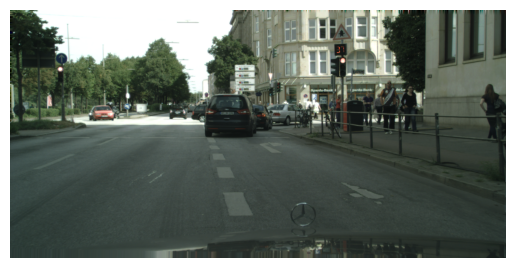

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img
import tensorflow as tf

# Define the paths to the images and masks folders
images_folder = "/content/images/"
masks_folder = "/content/masks/"

plt.axis("off")
plt.imshow(load_img("images/hamburg_000000_047390_leftImg8bit.png"))


In [ ]:
#!rm /content/images/hamburg_000000_047390_leftImg8bit.png

from matplotlib import pyplot as plt
import shutil
import os
import tensorflow as tf
from glob2 import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU


In [ ]:
# Define the directory paths for images and masks
image_dir = '/content/images/'
mask_dir = '/content/masks/'

# Get a list of image and mask file paths
image_files = sorted(glob(image_dir + '*.png'))
mask_files = sorted(glob(mask_dir + '*.png'))

# Print a few file paths to check
print("number of images:", len(image_files))
print("number of masks:", len(mask_files))

number of images: 370
number of masks: 370


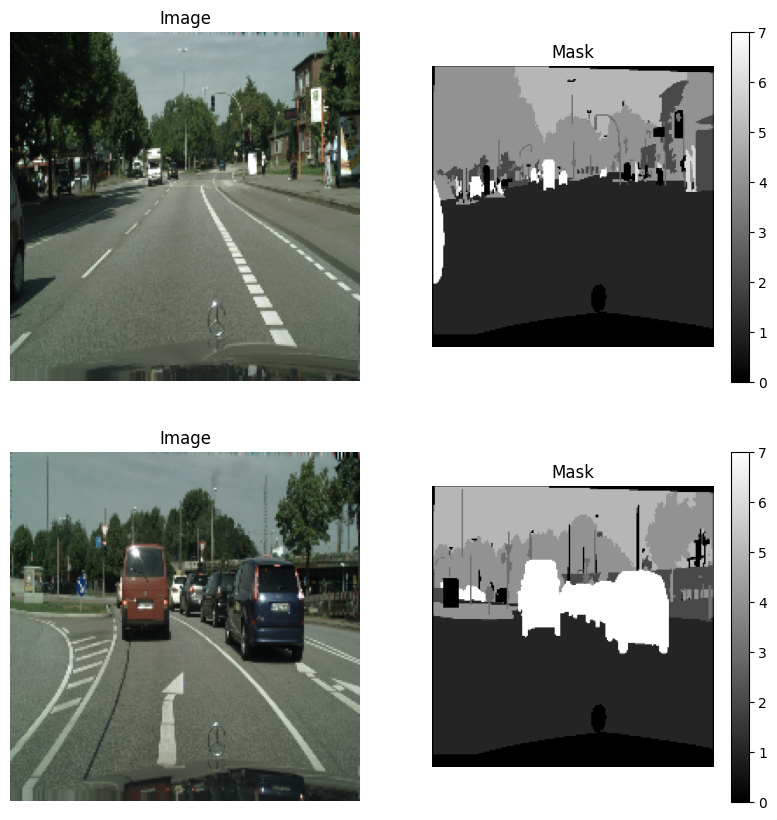

In [ ]:

# Create a dataset containing tuples of the form (image_path, mask_path)
files_ds = tf.data.Dataset.from_tensor_slices((image_files, mask_files))

# Define functions for loading and processing images and masks
def normalize(input_image, type):
    if type == "mask":
        return tf.cast(input_image, tf.int32)
    else:
        return tf.cast(input_image, tf.float32) / 255.0

def process_image(image_path, type):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3) if type != "mask" else tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, size=(200, 200))
    img = normalize(img, type)
    return img

# Map the process_image function to each image and mask path in files_ds
ds = files_ds.map(lambda img, mask: (process_image(img, type="img"), process_image(mask, type="mask")))

# Batch and prefetch the dataset
ds = ds.batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)


# Display a batch of images with their masks
for image_batch, mask_batch in ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(2):
        plt.subplot(2, 2, i*2 + 1) # GEN AI code
        plt.imshow(image_batch[i])
        plt.title("Image")
        plt.axis('off')

        plt.subplot(2, 2, i*2 + 2) #GEN AI code
        plt.imshow(mask_batch[i][:, :, 0], cmap='gray')
        plt.title("Mask")
        plt.colorbar()
        plt.axis('off')


    plt.show()


**2. (4pt) Prepare images and train a Unet model similar to lab2 for image segmentation Compute Mean Intersection Over Union for validation set in each epoch. Set ignore_class=0 in MeanIou function to ignore the void class in metric calculation.**


**Model building, Compiling and Fitting the Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU

# Create dataset from file paths
ds = tf.data.Dataset.from_tensor_slices((image_files, mask_files))


def normalize(input_image, type):
    if type == "mask":
        #mask = tf.cast(input_image, tf.int32)
        #mask = tf.clip_by_value(mask, 0, 2)

        return tf.cast(input_image, tf.int32)
    else:
        # Normalize the image by dividing its pixels by 255.
        return tf.cast(input_image, tf.float32) / 255.0

def process_image(image_path, type):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3) if type != "mask" else tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, size=(200, 200))
    img = normalize(img, type)
    return img


# Map the preprocessing function to the dataset
ds = ds.map(lambda img_path, mask_path: (process_image(img_path, type="img"), process_image(mask_path, type="mask")))


# Define dataset sizes
total_samples = len(image_files)
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size

# Split dataset into training and validation sets
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size)

# Batch and prefetch the datasets
batch_size = 8
train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Verify dataset shapes
print("Training dataset size:", train_size)
print("Validation dataset size:", val_size)


# Define U-Net model
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=(200,200), num_classes=8)
model.summary()

Training dataset size: 296
Validation dataset size: 74
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_28 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 conv2d_29 (Conv2D)          (None, 100, 100, 64)      36928     
                                                                 
 conv2d_30 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 conv2d_31 (Conv2D)          (None, 50, 50, 128)       147584    
                                                                 
 conv2d_32 (Conv2D)          (None, 25, 25, 256)       295168    
                                                                 
 con

In [ ]:
# Configure and compile the model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=[tf.keras.metrics.MeanIoU(num_classes=8, ignore_class=0, sparse_y_pred=False)]
              )

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

# Train the model
history = model.fit(
                    train_ds,
                    epochs=50,
                    validation_data=val_ds,
                    callbacks=callbacks
                    )

Epoch 1/50
37/37 [==============================] - 22s 344ms/step - loss: 2.0212 - mean_io_u_3: 0.0611 - val_loss: 1.7361 - val_mean_io_u_3: 0.0622 - lr: 0.0010
Epoch 2/50
37/37 [==============================] - 3s 94ms/step - loss: 1.7675 - mean_io_u_3: 0.0631 - val_loss: 1.7878 - val_mean_io_u_3: 0.0623 - lr: 0.0010
Epoch 3/50
37/37 [==============================] - 5s 150ms/step - loss: 1.7261 - mean_io_u_3: 0.0632 - val_loss: 1.6319 - val_mean_io_u_3: 0.0622 - lr: 0.0010
Epoch 4/50
37/37 [==============================] - 5s 144ms/step - loss: 1.4773 - mean_io_u_3: 0.0929 - val_loss: 1.3550 - val_mean_io_u_3: 0.1358 - lr: 0.0010
Epoch 5/50
37/37 [==============================] - 5s 145ms/step - loss: 1.1835 - mean_io_u_3: 0.1672 - val_loss: 1.2165 - val_mean_io_u_3: 0.1836 - lr: 0.0010
Epoch 6/50
37/37 [==============================] - 5s 146ms/step - loss: 1.1012 - mean_io_u_3: 0.2093 - val_loss: 1.0922 - val_mean_io_u_3: 0.2256 - lr: 0.0010
Epoch 7/50
37/37 [================

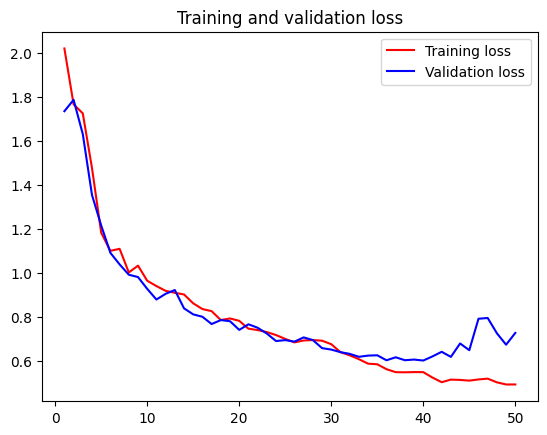

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

**3. (3pt) Tune the learning rate as well as the unet model architecture by adding more (convolution and transpose layer). Explain how these changes affects validation MeanIOU.**


In [ ]:
# Create dataset from file paths
ds_2 = tf.data.Dataset.from_tensor_slices((image_files, mask_files))


def normalize_2(input_image, type):
    if type == "mask":
        #mask = tf.cast(input_image, tf.int32)
        #mask = tf.clip_by_value(mask, 0, 2)
        return tf.cast(input_image, tf.int32)
    else:
        # Normalize the image by dividing its pixels by 255.
        return tf.cast(input_image, tf.float32) / 255.0

def process_image_2(image_path, type):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3) if type != "mask" else tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, size=(200, 200))
    img = normalize_2(img, type)
    return img


# Map the preprocessing function to the dataset
ds_2 = ds_2.map(lambda img_path, mask_path: (process_image_2(img_path, type="img"), process_image_2(mask_path, type="mask")))


# Define dataset sizes
total_samples = len(image_files)
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size

# Split dataset into training and validation sets
train_ds = ds_2.take(train_size)
val_ds = ds_2.skip(train_size)

# Batch and prefetch the datasets
batch_size = 8
train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Verify dataset shapes
print("Training dataset size:", train_size)
print("Validation dataset size:", val_size)


# Define U-Net model
def get_model_2(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Conv2D(64, 3, strides=1, activation="relu", padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=1, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(512, 3, strides=1, padding="same", activation="relu")(x)
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(512, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(512, 3, activation="relu", padding="same", strides=1)(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=1)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=1)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=1)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

#Create the U-Net model
model_2 = get_model_2(img_size=(200,200), num_classes=8)
model_2.summary()


Training dataset size: 296
Validation dataset size: 74
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_35 (Conv2D)          (None, 200, 200, 64)      1792      
                                                                 
 conv2d_36 (Conv2D)          (None, 200, 200, 64)      36928     
                                                                 
 conv2d_37 (Conv2D)          (None, 200, 200, 128)     73856     
                                                                 
 conv2d_38 (Conv2D)          (None, 200, 200, 128)     147584    
                                                                 
 conv2d_39 (Conv2D)          (None, 200, 200, 256)     295168    
                                                                 
 con

In [ ]:
# Configure and compile the model
model_2.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=[tf.keras.metrics.MeanIoU(num_classes=8, ignore_class = 0, sparse_y_pred=False)]
              )

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     patience=10,
                                     min_delta=1e-5,
                                     restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

# Train the model
history_2 = model_2.fit(
                    train_ds,
                    epochs=50,
                    validation_data=val_ds,
                    callbacks=callbacks
                    )


Epoch 1/50
37/37 [==============================] - 159s 4s/step - loss: 17.2572 - mean_io_u_5: 0.0604 - val_loss: 1.6584 - val_mean_io_u_5: 0.0630 - lr: 0.0010
Epoch 2/50
37/37 [==============================] - 131s 4s/step - loss: 1.7502 - mean_io_u_5: 0.0552 - val_loss: 1.6227 - val_mean_io_u_5: 0.0622 - lr: 0.0010
Epoch 3/50
37/37 [==============================] - 132s 4s/step - loss: 1.7852 - mean_io_u_5: 0.0552 - val_loss: 1.6001 - val_mean_io_u_5: 0.0622 - lr: 0.0010
Epoch 4/50
37/37 [==============================] - 128s 3s/step - loss: 1.7335 - mean_io_u_5: 0.0545 - val_loss: 1.6227 - val_mean_io_u_5: 0.0622 - lr: 0.0010
Epoch 5/50
37/37 [==============================] - 128s 3s/step - loss: 1.7277 - mean_io_u_5: 0.0631 - val_loss: 1.6444 - val_mean_io_u_5: 0.0622 - lr: 0.0010
Epoch 6/50
37/37 [==============================] - 128s 3s/step - loss: 1.6914 - mean_io_u_5: 0.0552 - val_loss: 1.6730 - val_mean_io_u_5: 0.0622 - lr: 0.0010
Epoch 7/50
37/37 [=====================

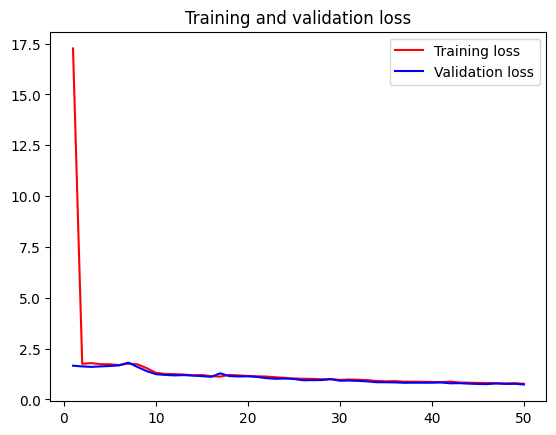

In [ ]:
epochs = range(1, len(history_2.history["loss"]) + 1)
loss = history_2.history["loss"]
val_loss = history_2.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

**4. (2pt) Display some images from validation data together with their true and predicted masks.**

1/1 [==============================] - 0s 235ms/step


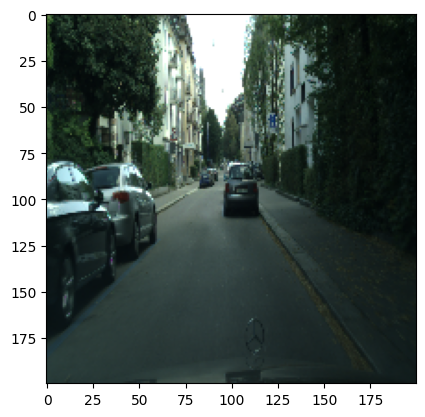

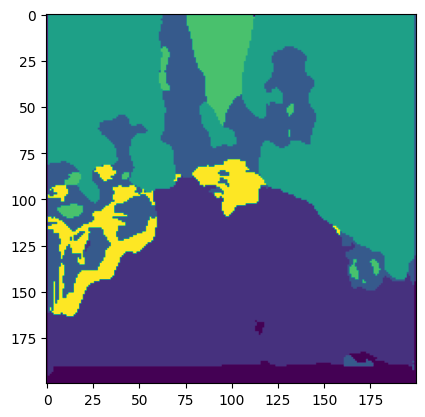

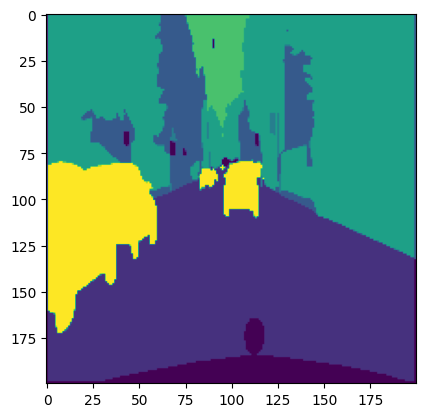

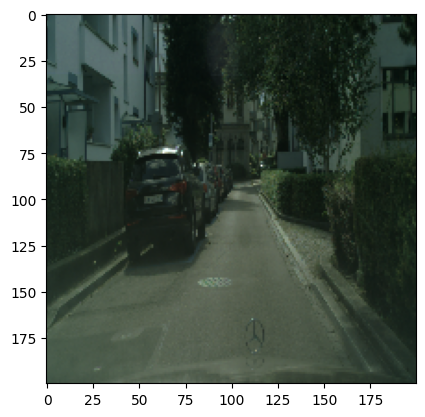

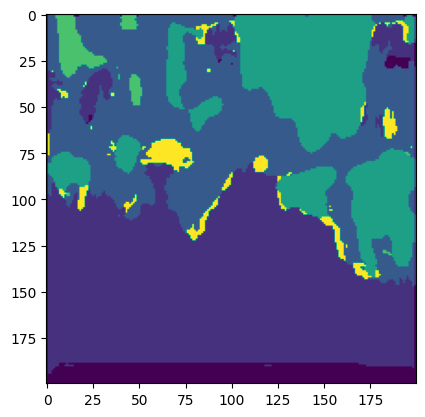

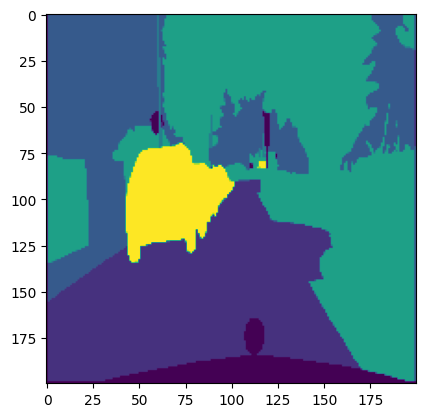

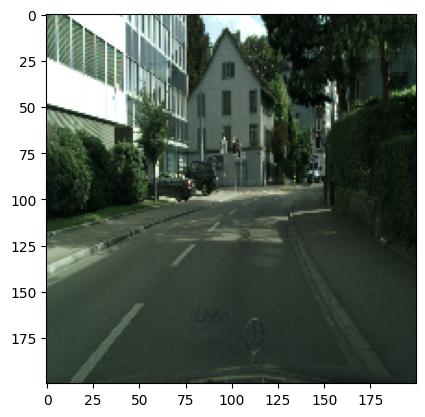

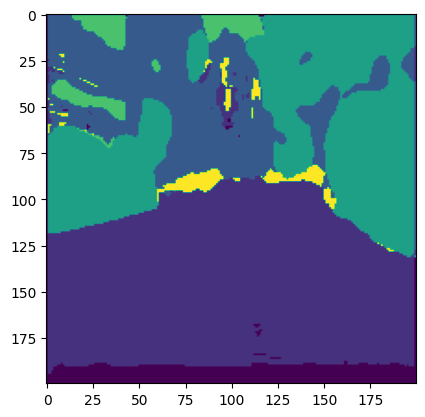

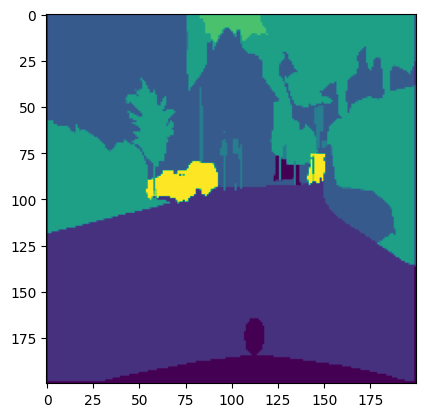

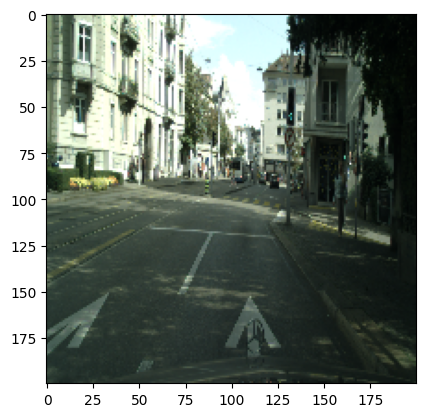

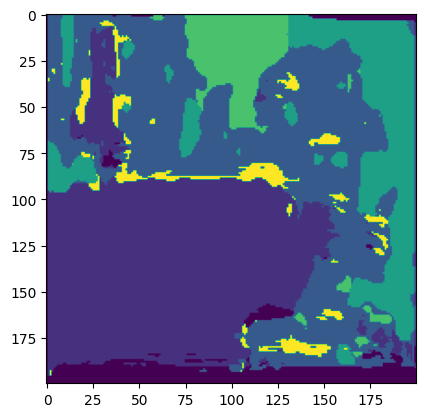

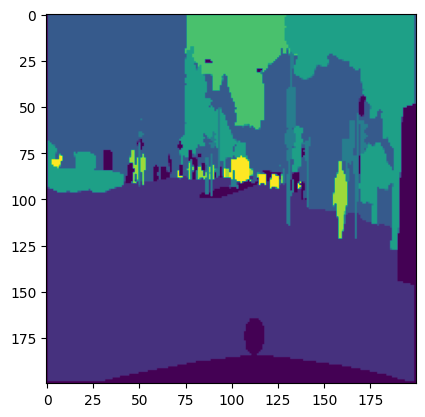

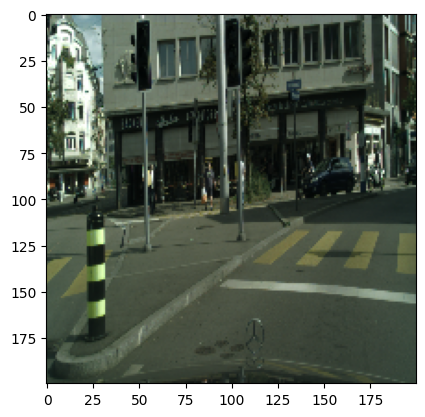

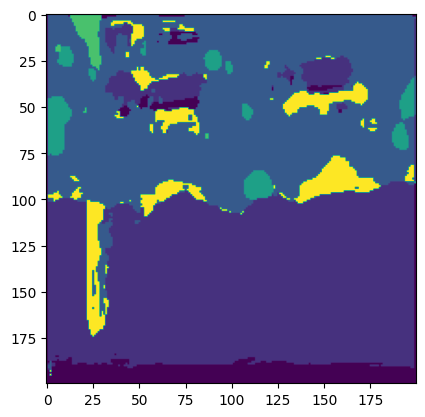

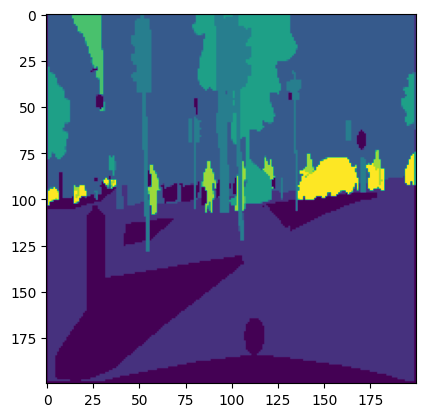

In [ ]:
import numpy as np


#load the checkpointed model
checkpoint_model=keras.models.load_model("oxford_segmentation")

for x,y in val_ds.take(1):
  #use the model to predict pixel mask for the images in x
  preds = checkpoint_model.predict(x)

  #display the first five images in the batch together with their true mask and predicted mask
  for img,pred,true_mask in zip(x[:5],preds[:5],y[:5]):
    plt.imshow(tf.keras.utils.array_to_img(img))
    plt.show()

  #model's prediction for each image is of shape (200,200,3). The last axis holds the probability distribution over three pixel classes.
  #To display the output, we convert it to a single channel by taking the class with maximum predicted probability
    predicted_mask = np.argmax(pred, axis=-1)
  # show predicted mask
    plt.imshow(tf.keras.utils.array_to_img(tf.expand_dims(predicted_mask,-1)))
    plt.show()

  #show true mask
    plt.imshow(tf.keras.utils.array_to_img(true_mask))
    plt.show()

**Bonus (+3 pts)**
**Apply transfer learning by Replacing the first half of the UNET model with pretrained model (e.g., DenseNet) with frozen weights. Does this improve Mean IOU on the validation data?**

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import UpSampling2D
# import tensorflow as tf
# from tensorflow.keras.metrics import MeanIoU

# # Create dataset from file paths
# ds = tf.data.Dataset.from_tensor_slices((image_files, mask_files))


# def normalize(input_image, type):
#     if type == "mask":
#         #mask = tf.cast(input_image, tf.int32)
#         #mask = tf.clip_by_value(mask, 0, 2)

#         return tf.cast(input_image, tf.int32)
#     else:
#         # Normalize the image by dividing its pixels by 255.
#         return tf.cast(input_image, tf.float32) / 255.0

# def process_image(image_path, type):
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_png(img, channels=3) if type != "mask" else tf.image.decode_png(img, channels=1)
#     img = tf.image.resize(img, size=(200, 200))
#     img = normalize(img, type)
#     return img


# # Map the preprocessing function to the dataset
# ds = ds.map(lambda img_path, mask_path: (process_image(img_path, type="img"), process_image(mask_path, type="mask")))


# # Define dataset sizes
# total_samples = len(image_files)
# train_size = int(0.8 * total_samples)
# val_size = total_samples - train_size

# # Split dataset into training and validation sets
# train_ds = ds.take(train_size)
# val_ds = ds.skip(train_size)

# # Batch and prefetch the datasets
# batch_size = 8
# train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# # Verify dataset shapes
# print("Training dataset size:", train_size)
# print("Validation dataset size:", val_size)



# # Define dataset sizes
# total_samples = len(image_files)
# train_size = int(0.8 * total_samples)
# val_size = total_samples - train_size

# # Split dataset into training and validation sets
# train_ds = ds.take(train_size)
# val_ds = ds.skip(train_size)

# # Batch and prefetch the datasets
# batch_size = 8
# train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Load DenseNet model pretrained on ImageNet with frozen weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Freeze the layers in the base model
base_model.trainable = False

# Define U-Net model with DenseNet base
def get_model_3(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    x = base_model(inputs, training=False)  # Use pretrained DenseNet as base
    x = layers.Conv2DTranspose(512, 3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same', strides=2)(x)
    #x = UpSampling2D(size=(2, 2))(x)
    x = tf.image.resize(x, (200, 200))
    outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)
    model = keras.Model(inputs, outputs)
    return model

model_3 = get_model_3(img_size=(200,200), num_classes=8)
model_3.summary()

Training dataset size: 296
Validation dataset size: 74
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 6, 6, 1024)        7037504   
                                                                 
 conv2d_transpose_54 (Conv2  (None, 12, 12, 512)       4719104   
 DTranspose)                                                     
                                                                 
 conv2d_transpose_55 (Conv2  (None, 24, 24, 256)       1179904   
 DTranspose)                                                     
                                                                 
 conv2d_transpose_56 (Conv2  (None, 48, 48, 128)       295040    
 DTranspose)                                                     
   

In [ ]:

# Configure and compile the model
model_3.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=[tf.keras.metrics.MeanIoU(num_classes=8, ignore_class=0, sparse_y_pred=False)]
              )

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

# Train the model
history_3 = model_3.fit(
                    train_ds,
                    epochs=50,
                    validation_data=val_ds,
                    callbacks=callbacks,
                    )



Epoch 1/50
37/37 [==============================] - 59s 1s/step - loss: 1.4080 - mean_io_u_10: 0.1055 - val_loss: 1.0666 - val_mean_io_u_10: 0.1589 - lr: 0.0010
Epoch 2/50
37/37 [==============================] - 38s 1s/step - loss: 1.0290 - mean_io_u_10: 0.1812 - val_loss: 0.9713 - val_mean_io_u_10: 0.2025 - lr: 0.0010
Epoch 3/50
37/37 [==============================] - 38s 1s/step - loss: 0.9520 - mean_io_u_10: 0.2069 - val_loss: 0.9034 - val_mean_io_u_10: 0.2135 - lr: 0.0010
Epoch 4/50
37/37 [==============================] - 39s 1s/step - loss: 0.8587 - mean_io_u_10: 0.2565 - val_loss: 0.8400 - val_mean_io_u_10: 0.2851 - lr: 0.0010
Epoch 5/50
37/37 [==============================] - 38s 1s/step - loss: 0.7991 - mean_io_u_10: 0.2861 - val_loss: 0.8387 - val_mean_io_u_10: 0.2972 - lr: 0.0010
Epoch 6/50
37/37 [==============================] - 3s 70ms/step - loss: 0.7727 - mean_io_u_10: 0.3186 - val_loss: 0.8564 - val_mean_io_u_10: 0.3191 - lr: 0.0010
Epoch 7/50
37/37 [===============

This model has better performance than above 2 models. We can see higher MeanIOU and lower validation loss.